In [1]:
%pylab inline
import numpy as np
from scipy.stats import norm
import pyccl as ccl
from astropy.io import fits
import lenstools as lt
from lenstools import ConvergenceMap 
import astropy.units as u

Populating the interactive namespace from numpy and matplotlib


In [2]:
k_ia_array=np.load("k_ia_array.npy")
m_array=np.load("m_array.npy")
nz=np.load("nz.npy")

In [3]:
def binz_kappa(m_ar,nz_s,nbin):
    tom_kappa=0
    for i in range(len(m_ar)):
        tom_kappa=tom_kappa+(nz_s[nbin][i]*m_ar[i][0])
    return tom_kappa

In [4]:
kiabin0=binz_kappa(k_ia_array,nz,0)
kiabin1=binz_kappa(k_ia_array,nz,1)
kiabin2=binz_kappa(k_ia_array,nz,2)

kbin0=binz_kappa(m_array,nz,0)
kbin1=binz_kappa(m_array,nz,1)
kbin2=binz_kappa(m_array,nz,2)

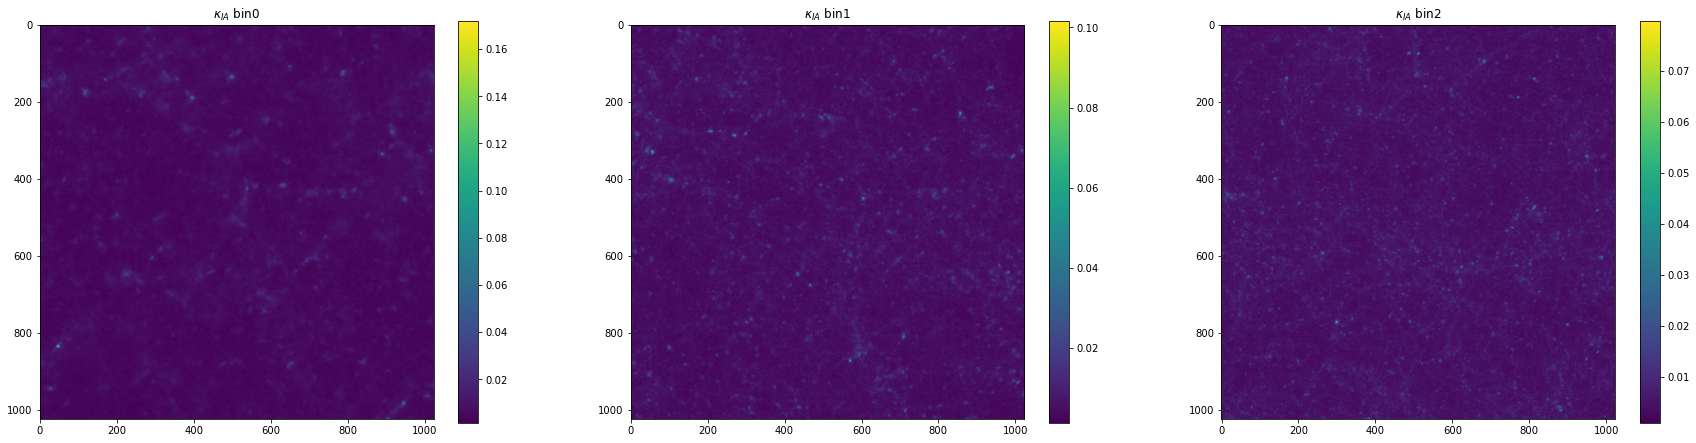

In [5]:
figure(figsize=[30,10])
subplot(131)
imshow(-kiabin0)
title('$\kappa_{IA}$ bin0')
colorbar(shrink=0.74)
subplot(132)
imshow(-kiabin1)
title('$\kappa_{IA}$ bin1')
colorbar(shrink=0.74)
subplot(133)
imshow(-kiabin2)
title('$\kappa_{IA}$ bin2')
colorbar(shrink=0.74)

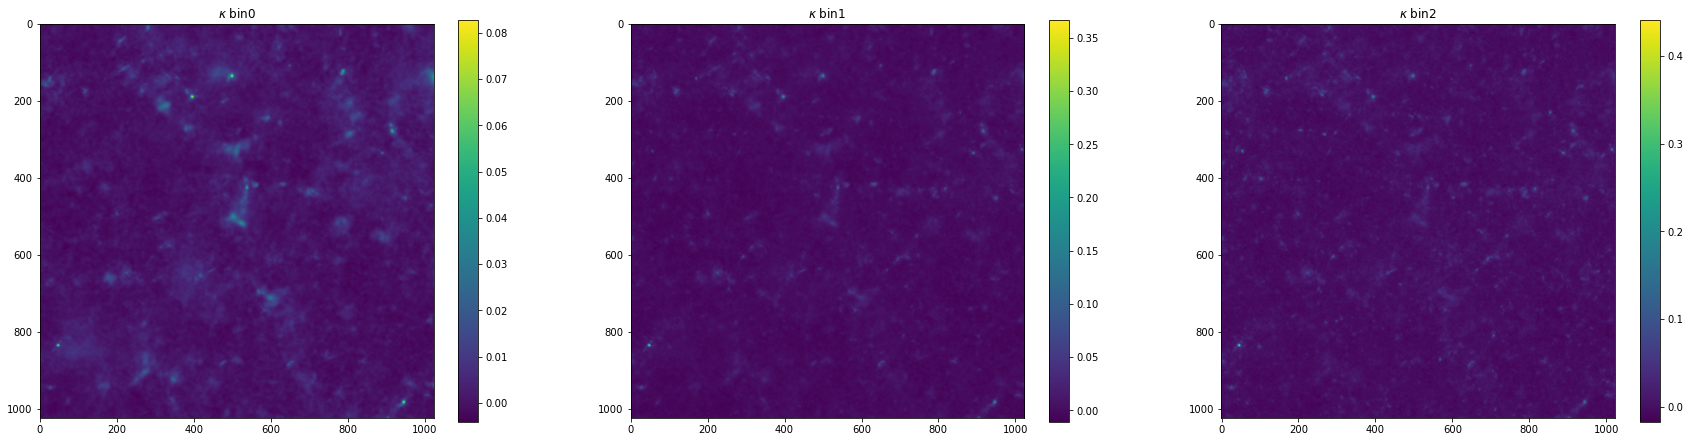

In [6]:
figure(figsize=[30,10])
subplot(131)
imshow(kbin0)
title('$\kappa$ bin0')
colorbar(shrink=0.74)
subplot(132)
imshow(kbin1)
title('$\kappa$ bin1')
colorbar(shrink=0.74)
subplot(133)
imshow(kbin2)
title('$\kappa$ bin2')
colorbar(shrink=0.74)

In [7]:
ell = np.arange(300.0,3000.0,20.0)

In [8]:
kiabin0 = lt.ConvergenceMap(kiabin0, 5*u.deg)
kiabin1 = lt.ConvergenceMap(kiabin1, 5*u.deg)
kiabin2 = lt.ConvergenceMap(kiabin2, 5*u.deg)

In [9]:
kbin0 = lt.ConvergenceMap(kbin0, 5*u.deg)
kbin1 = lt.ConvergenceMap(kbin1, 5*u.deg)
kbin2 = lt.ConvergenceMap(kbin2, 5*u.deg)

In [10]:
l0,Pl00_ia = kiabin0.powerSpectrum(ell)
l1,Pl11_ia = kiabin1.powerSpectrum(ell)
l2,Pl22_ia = kiabin2.powerSpectrum(ell)

In [11]:
l0,Pl00 = kbin0.powerSpectrum(ell)
l1,Pl11 = kbin1.powerSpectrum(ell)
l2,Pl22 = kbin2.powerSpectrum(ell)

In [12]:
l01,Pl01_ia = kiabin0.cross(kiabin1,l_edges=ell)
l02,Pl02_ia = kiabin0.cross(kiabin2,l_edges=ell)
l12,Pl12_ia = kiabin1.cross(kiabin2,l_edges=ell)

In [13]:
l01,Pl01 = kbin0.cross(kbin1,l_edges=ell)
l02,Pl02 = kbin0.cross(kbin2,l_edges=ell)
l12,Pl12 = kbin1.cross(kbin2,l_edges=ell)

In [14]:
p_ia_stack=np.stack([Pl00_ia,Pl01_ia,Pl11_ia,Pl02_ia,Pl12_ia,Pl22_ia])

In [15]:
p_stack=np.stack([Pl00,Pl01,Pl11,Pl02,Pl12,Pl22])

In [16]:
cosmo_ccl = ccl.Cosmology(
    Omega_c=0.2589, Omega_b=0.0486, 
    h=0.6774, sigma8 = 0.8159, n_s=0.9667, Neff=0,
    transfer_function='eisenstein_hu', matter_power_spectrum='halofit')

In [17]:
z_source=np.array([0.03435981, 0.10539865, 0.17847598, 0.25470996, 0.33486116,
       0.4182421 , 0.5060408 , 0.59879637, 0.6976799 , 0.8020377 ,
       0.9134468 ])

In [18]:
tracers_ia = []
for i in range(3):
    t_i = ccl.WeakLensingTracer(cosmo_ccl, (z_source, nz[i]), has_shear=False, ia_bias=(z_source, np.ones_like(z_source)), use_A_ia=True)
    tracers_ia.append(t_i)

In [19]:
tracers = []
for i in range(3):
    t_i = ccl.WeakLensingTracer(cosmo_ccl, (z_source, nz[i]),use_A_ia=False )
    tracers.append(t_i)

In [20]:
ell=l0

In [21]:
cls={}
cross=[]
for i in range(3):
    for j in range(i+1):
        cross.append(ccl.angular_cl(cosmo_ccl, tracers_ia[i], tracers_ia[j], ell))
cls['II,NLA'] = np.stack(cross)

cross=[]
for i in range(3):
    for j in range(i+1):
        cross.append(ccl.angular_cl(cosmo_ccl, tracers[i], tracers[j], ell))
cls['GG'] = np.stack(cross)

In [22]:
p_stack=np.stack([Pl00,Pl01,Pl11,Pl02,Pl12,Pl22])

In [23]:
Bin=['1-1','1-2','2-2','1-3','2-3','3-3']

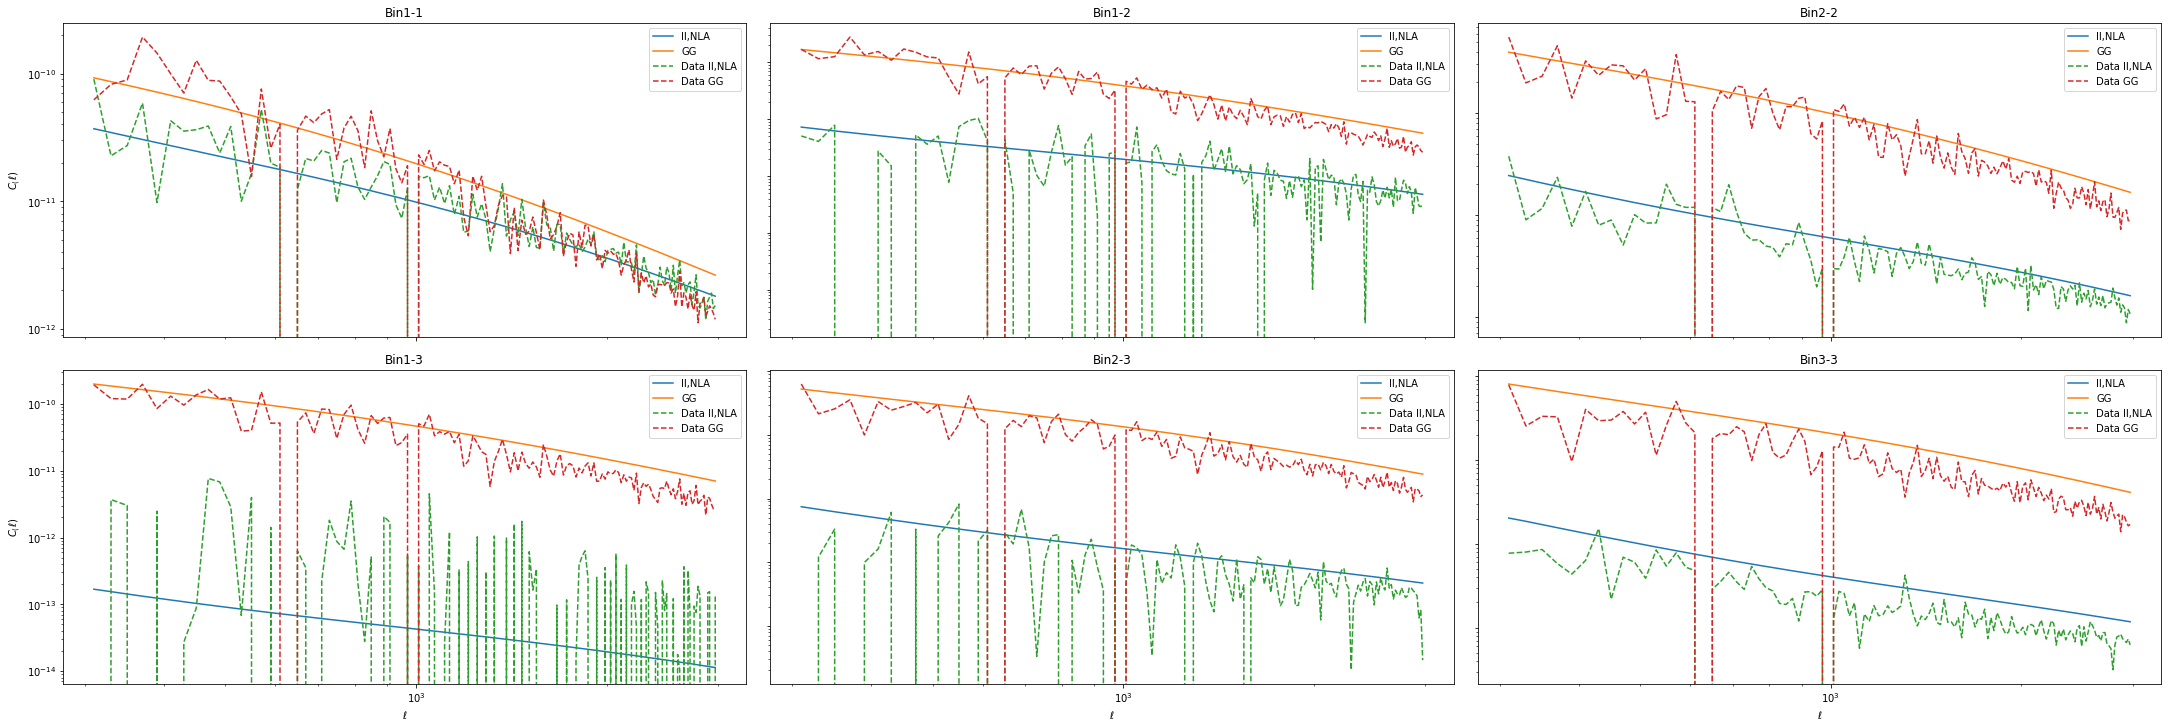

In [24]:
figsize = (30, 10)
fig =plt.figure(figsize=figsize, constrained_layout=True)
cols = 3
rows =2
ax = fig.subplots(rows, cols)
for j in range(6):
    ax.flatten()[j].loglog(ell, cls['II,NLA'][j],label='II,NLA')
    ax.flatten()[j].loglog(ell, cls['GG'][j],label='GG')
    ax.flatten()[j].loglog(ell, p_ia_stack[j],'--',label='Data II,NLA')
    ax.flatten()[j].loglog(ell, p_stack[j],'--',label='Data GG')
    ax.flatten()[j].set_title('Bin'+Bin[j])
    ax.flatten()[j].set(xlabel=r'$\ell$', ylabel=r'$C_(\ell)$')
    ax.flatten()[j].legend()
    # Hide x labels and tick labels for top plots and y ticks for right plots.
    ax.flatten()[j].label_outer()

